In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU device:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
Number of GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA RTX A2000


In [ ]:
import transformers
import accelerate

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")


Transformers version: 4.44.2
Accelerate version: 0.34.2


In [ ]:
"""
VALIDATION ON CBIT AND ROC AUC CURVE

"""
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

def cbit_eval(val_dataset=None,batch_size=64,modelname="BERT_BASE_CBIT"):
    device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = AutoModelForSequenceClassification.from_pretrained(modelname,num_labels=4)
    model.to(device).eval()
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    labels_one_hot=torch.nn.functional.one_hot(all_valid_labels, num_classes=all_valid_preds.shape[1]).cpu().numpy()
    preds=all_valid_preds.cpu().numpy()
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(preds.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(labels_one_hot[:, i], preds[:, i])
        roc_auc[i] = roc_auc_score(labels_one_hot[:, i], preds[:, i])

    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one_hot.ravel(), preds.ravel())
    roc_auc["micro"] = roc_auc_score(labels_one_hot, preds, average="micro")

    plt.figure(figsize=(10,6))
    for i in range(preds.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(modelname+ 'Receiver Operating Characteristic (ROC) curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# 2. BERT TRAINING

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

# Load data
data = pd.read_csv(r"C:\Users\l\Desktop\proj\MP\BERT-Based-Approach-for-Automating-Course-Articulation-Matrix-Construction-with-Explainable-AI-main\DATASET\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']
X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()

    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)

        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)

    epoch_time = time.time() - epoch_start_time

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

bert_base_model_save_path = 'bert_model_trained.pth'
torch.save(model.state_dict(), bert_base_model_save_path)

print(f"Model saved to {bert_base_model_save_path}")

C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/112 [00:00<?, ?it/s]C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp

Epoch 1/10, Train Loss: 0.0147, Train Acc: 0.5719, Train Precision: 0.5514, Train Recall: 0.5719, Train F1: 0.5504, Valid Loss: 0.0087, Valid Acc: 0.7553, Valid Precision: 0.7544, Valid Recall: 0.7553, Valid F1: 0.7546, Epoch Time: 95.85 seconds


100%|██████████| 112/112 [01:34<00:00,  1.18it/s]


Epoch 2/10, Train Loss: 0.0064, Train Acc: 0.8247, Train Precision: 0.8207, Train Recall: 0.8247, Train F1: 0.8217, Valid Loss: 0.0057, Valid Acc: 0.8469, Valid Precision: 0.8430, Valid Recall: 0.8469, Valid F1: 0.8443, Epoch Time: 102.41 seconds


100%|██████████| 112/112 [01:32<00:00,  1.21it/s]


Epoch 3/10, Train Loss: 0.0041, Train Acc: 0.8955, Train Precision: 0.8945, Train Recall: 0.8955, Train F1: 0.8949, Valid Loss: 0.0038, Valid Acc: 0.9034, Valid Precision: 0.9069, Valid Recall: 0.9034, Valid F1: 0.9030, Epoch Time: 100.25 seconds


100%|██████████| 112/112 [01:32<00:00,  1.20it/s]


Epoch 4/10, Train Loss: 0.0026, Train Acc: 0.9392, Train Precision: 0.9390, Train Recall: 0.9392, Train F1: 0.9391, Valid Loss: 0.0037, Valid Acc: 0.9162, Valid Precision: 0.9156, Valid Recall: 0.9162, Valid F1: 0.9150, Epoch Time: 100.35 seconds


100%|██████████| 112/112 [01:33<00:00,  1.20it/s]


Epoch 5/10, Train Loss: 0.0018, Train Acc: 0.9596, Train Precision: 0.9596, Train Recall: 0.9596, Train F1: 0.9596, Valid Loss: 0.0039, Valid Acc: 0.9101, Valid Precision: 0.9085, Valid Recall: 0.9101, Valid F1: 0.9087, Epoch Time: 100.68 seconds


100%|██████████| 112/112 [01:32<00:00,  1.21it/s]


Epoch 6/10, Train Loss: 0.0012, Train Acc: 0.9749, Train Precision: 0.9748, Train Recall: 0.9749, Train F1: 0.9748, Valid Loss: 0.0030, Valid Acc: 0.9402, Valid Precision: 0.9404, Valid Recall: 0.9402, Valid F1: 0.9403, Epoch Time: 100.23 seconds


100%|██████████| 112/112 [01:32<00:00,  1.21it/s]


Epoch 7/10, Train Loss: 0.0008, Train Acc: 0.9841, Train Precision: 0.9841, Train Recall: 0.9841, Train F1: 0.9841, Valid Loss: 0.0033, Valid Acc: 0.9341, Valid Precision: 0.9340, Valid Recall: 0.9341, Valid F1: 0.9336, Epoch Time: 99.65 seconds


100%|██████████| 112/112 [01:32<00:00,  1.21it/s]


Epoch 8/10, Train Loss: 0.0009, Train Acc: 0.9811, Train Precision: 0.9811, Train Recall: 0.9811, Train F1: 0.9811, Valid Loss: 0.0038, Valid Acc: 0.9318, Valid Precision: 0.9327, Valid Recall: 0.9318, Valid F1: 0.9309, Epoch Time: 99.65 seconds


100%|██████████| 112/112 [01:33<00:00,  1.20it/s]


Epoch 9/10, Train Loss: 0.0006, Train Acc: 0.9883, Train Precision: 0.9883, Train Recall: 0.9883, Train F1: 0.9883, Valid Loss: 0.0027, Valid Acc: 0.9480, Valid Precision: 0.9504, Valid Recall: 0.9480, Valid F1: 0.9479, Epoch Time: 100.83 seconds


100%|██████████| 112/112 [01:32<00:00,  1.22it/s]


Epoch 10/10, Train Loss: 0.0004, Train Acc: 0.9941, Train Precision: 0.9941, Train Recall: 0.9941, Train F1: 0.9941, Valid Loss: 0.0025, Valid Acc: 0.9570, Valid Precision: 0.9568, Valid Recall: 0.9570, Valid F1: 0.9569, Epoch Time: 99.37 seconds
Total training time: 999.29 seconds
Model saved to bert_model_trained.pth


In [ ]:
model.save_pretrained("BERT_BASE_CBIT")

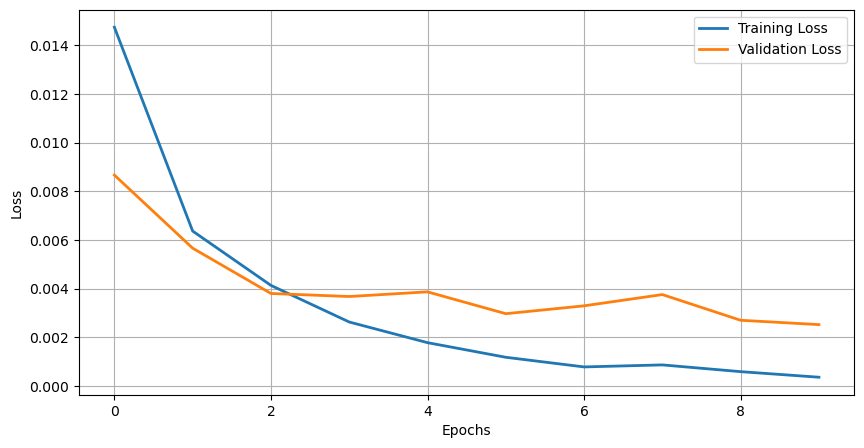

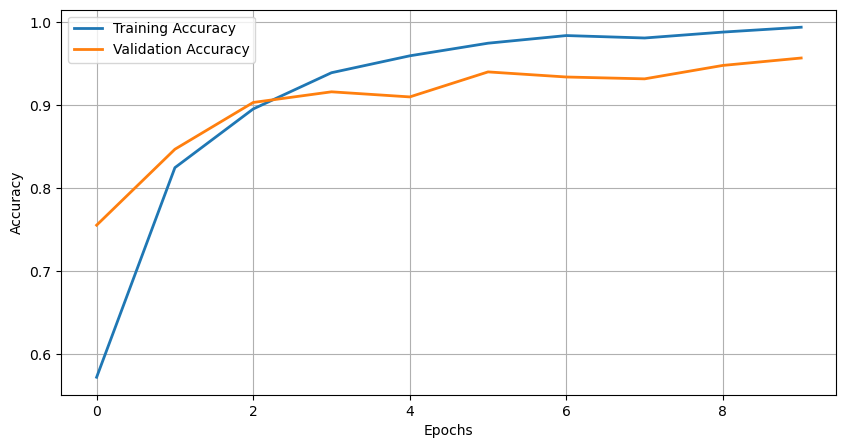

In [ ]:
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_dataset = Dataset(val_encodings, y_val.tolist())

C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


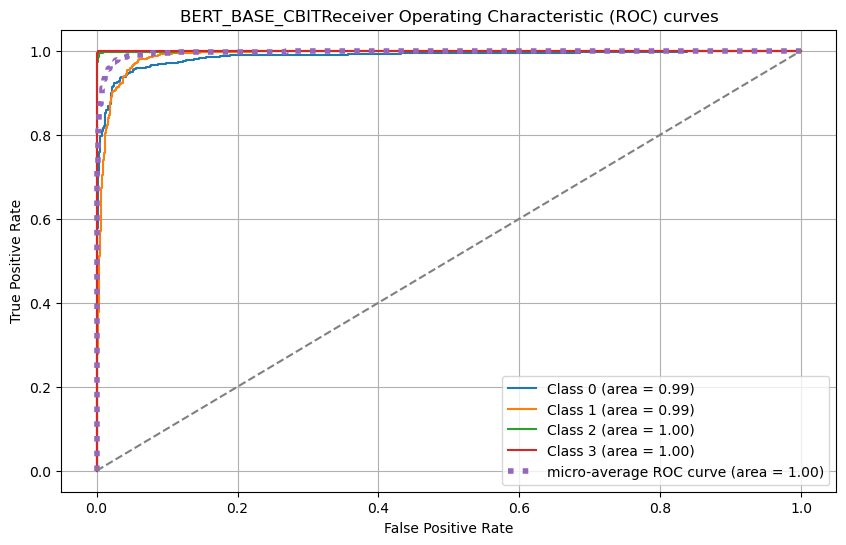

In [ ]:
cbit_eval(val_dataset=val_dataset,batch_size=64,modelname="BERT_BASE_CBIT")

# 3.DISTILBERT TRAINING

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

data = pd.read_csv(r"C:\Users\l\Desktop\proj\MP\BERT-Based-Approach-for-Automating-Course-Articulation-Matrix-Construction-with-Explainable-AI-main\DATASET\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

distilbert_model_save_path = 'distilbert_model_trained.pth'
torch.save(model.state_dict(), distilbert_model_save_path)

print(f"Model saved to {distilbert_model_save_path}")

C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 112/112 [00:47<00:00,  2.38it/s]


Epoch 1/10, Train Loss: 0.0152, Train Acc: 0.5692, Train Precision: 0.5511, Train Recall: 0.5692, Train F1: 0.5429, Valid Loss: 0.0088, Valid Acc: 0.7480, Valid Precision: 0.7379, Valid Recall: 0.7480, Valid F1: 0.7135, Epoch Time: 51.09 seconds


100%|██████████| 112/112 [00:47<00:00,  2.35it/s]


Epoch 2/10, Train Loss: 0.0067, Train Acc: 0.8251, Train Precision: 0.8192, Train Recall: 0.8251, Train F1: 0.8199, Valid Loss: 0.0061, Valid Acc: 0.8430, Valid Precision: 0.8395, Valid Recall: 0.8430, Valid F1: 0.8395, Epoch Time: 51.38 seconds


100%|██████████| 112/112 [00:47<00:00,  2.34it/s]


Epoch 3/10, Train Loss: 0.0042, Train Acc: 0.8965, Train Precision: 0.8951, Train Recall: 0.8965, Train F1: 0.8954, Valid Loss: 0.0042, Valid Acc: 0.8911, Valid Precision: 0.8893, Valid Recall: 0.8911, Valid F1: 0.8900, Epoch Time: 51.63 seconds


100%|██████████| 112/112 [00:48<00:00,  2.32it/s]


Epoch 4/10, Train Loss: 0.0028, Train Acc: 0.9357, Train Precision: 0.9353, Train Recall: 0.9357, Train F1: 0.9355, Valid Loss: 0.0042, Valid Acc: 0.9101, Valid Precision: 0.9100, Valid Recall: 0.9101, Valid F1: 0.9099, Epoch Time: 52.04 seconds


100%|██████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch 5/10, Train Loss: 0.0018, Train Acc: 0.9564, Train Precision: 0.9563, Train Recall: 0.9564, Train F1: 0.9563, Valid Loss: 0.0032, Valid Acc: 0.9263, Valid Precision: 0.9260, Valid Recall: 0.9263, Valid F1: 0.9256, Epoch Time: 52.35 seconds


100%|██████████| 112/112 [00:49<00:00,  2.28it/s]


Epoch 6/10, Train Loss: 0.0011, Train Acc: 0.9744, Train Precision: 0.9744, Train Recall: 0.9744, Train F1: 0.9744, Valid Loss: 0.0031, Valid Acc: 0.9235, Valid Precision: 0.9244, Valid Recall: 0.9235, Valid F1: 0.9231, Epoch Time: 53.00 seconds


100%|██████████| 112/112 [00:48<00:00,  2.30it/s]


Epoch 7/10, Train Loss: 0.0008, Train Acc: 0.9837, Train Precision: 0.9836, Train Recall: 0.9837, Train F1: 0.9836, Valid Loss: 0.0033, Valid Acc: 0.9402, Valid Precision: 0.9412, Valid Recall: 0.9402, Valid F1: 0.9402, Epoch Time: 52.55 seconds


100%|██████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch 8/10, Train Loss: 0.0008, Train Acc: 0.9835, Train Precision: 0.9835, Train Recall: 0.9835, Train F1: 0.9835, Valid Loss: 0.0028, Valid Acc: 0.9397, Valid Precision: 0.9419, Valid Recall: 0.9397, Valid F1: 0.9398, Epoch Time: 52.38 seconds


100%|██████████| 112/112 [00:50<00:00,  2.20it/s]


Epoch 9/10, Train Loss: 0.0005, Train Acc: 0.9881, Train Precision: 0.9881, Train Recall: 0.9881, Train F1: 0.9881, Valid Loss: 0.0024, Valid Acc: 0.9547, Valid Precision: 0.9547, Valid Recall: 0.9547, Valid F1: 0.9545, Epoch Time: 54.98 seconds


100%|██████████| 112/112 [00:50<00:00,  2.23it/s]


Epoch 10/10, Train Loss: 0.0004, Train Acc: 0.9929, Train Precision: 0.9929, Train Recall: 0.9929, Train F1: 0.9929, Valid Loss: 0.0030, Valid Acc: 0.9475, Valid Precision: 0.9474, Valid Recall: 0.9475, Valid F1: 0.9473, Epoch Time: 54.21 seconds
Total training time: 525.62 seconds
Model saved to distilbert_model_trained.pth


In [ ]:
model.save_pretrained("DISTILBERT_BASE_CBIT")

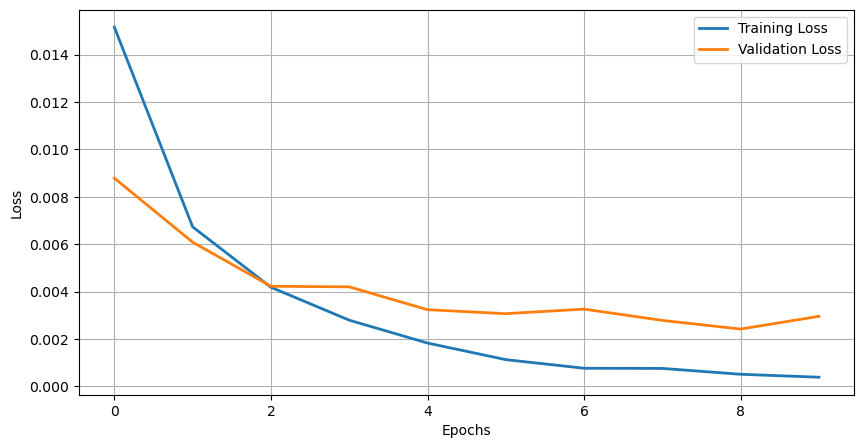

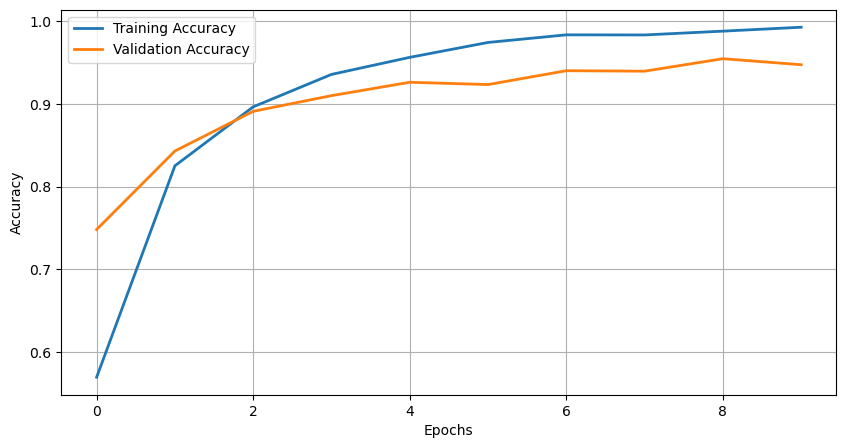

In [ ]:
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_dataset = Dataset(val_encodings, y_val.tolist())

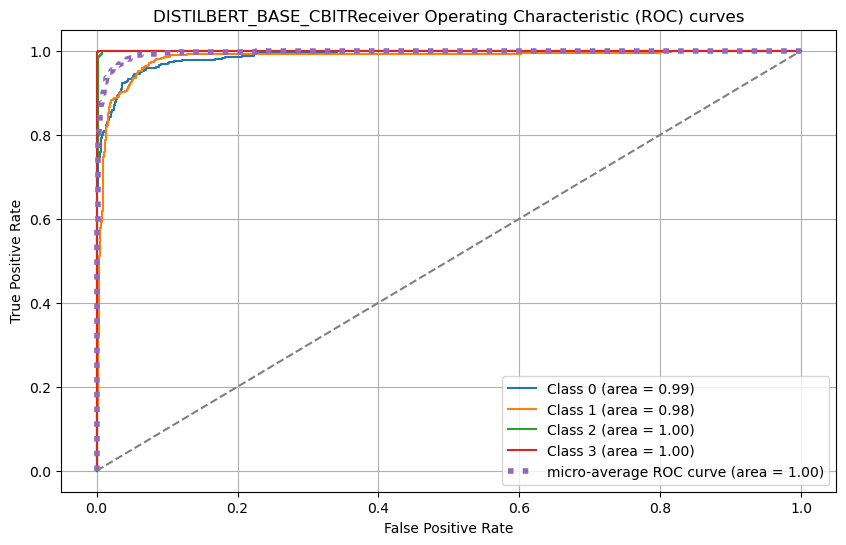

In [ ]:
cbit_eval(val_dataset=val_dataset,batch_size=64,modelname="DISTILBERT_BASE_CBIT")

# 4. ALBERT TRAINING

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import AlbertTokenizer, AlbertForSequenceClassification
import numpy as np
from tqdm import tqdm
import time

data = pd.read_csv(r"C:\Users\l\Desktop\proj\MP\BERT-Based-Approach-for-Automating-Course-Articulation-Matrix-Construction-with-Explainable-AI-main\DATASET\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=4)
device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)
    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)
    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")
albert_model_save_path = 'albert_model_trained1.pth'
torch.save(model.state_dict(), albert_model_save_path)

print(f"Model saved to {albert_model_save_path}")

C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 112/112 [09:11<00:00,  4.93s/it]


Epoch 1/10, Train Loss: 0.0217, Train Acc: 0.2717, Train Precision: 0.2556, Train Recall: 0.2717, Train F1: 0.2484, Valid Loss: 0.0217, Valid Acc: 0.2402, Valid Precision: 0.0577, Valid Recall: 0.2402, Valid F1: 0.0931, Epoch Time: 567.95 seconds


100%|██████████| 112/112 [08:40<00:00,  4.64s/it]


Epoch 2/10, Train Loss: 0.0219, Train Acc: 0.2675, Train Precision: 0.2562, Train Recall: 0.2675, Train F1: 0.2351, Valid Loss: 0.0217, Valid Acc: 0.2793, Valid Precision: 0.0780, Valid Recall: 0.2793, Valid F1: 0.1220, Epoch Time: 538.83 seconds


100%|██████████| 112/112 [09:05<00:00,  4.87s/it]


Epoch 3/10, Train Loss: 0.0216, Train Acc: 0.2928, Train Precision: 0.2782, Train Recall: 0.2928, Train F1: 0.2719, Valid Loss: 0.0217, Valid Acc: 0.2413, Valid Precision: 0.0582, Valid Recall: 0.2413, Valid F1: 0.0938, Epoch Time: 563.76 seconds


100%|██████████| 112/112 [08:57<00:00,  4.80s/it]


Epoch 4/10, Train Loss: 0.0214, Train Acc: 0.3098, Train Precision: 0.2934, Train Recall: 0.3098, Train F1: 0.2844, Valid Loss: 0.0200, Valid Acc: 0.4257, Valid Precision: 0.4281, Valid Recall: 0.4257, Valid F1: 0.3268, Epoch Time: 553.83 seconds


100%|██████████| 112/112 [09:02<00:00,  4.84s/it]


Epoch 5/10, Train Loss: 0.0176, Train Acc: 0.4909, Train Precision: 0.4679, Train Recall: 0.4909, Train F1: 0.4633, Valid Loss: 0.0139, Valid Acc: 0.6067, Valid Precision: 0.4936, Valid Recall: 0.6067, Valid F1: 0.5330, Epoch Time: 560.88 seconds


100%|██████████| 112/112 [08:55<00:00,  4.78s/it]


Epoch 6/10, Train Loss: 0.0124, Train Acc: 0.6632, Train Precision: 0.6451, Train Recall: 0.6632, Train F1: 0.6406, Valid Loss: 0.0110, Valid Acc: 0.6933, Valid Precision: 0.7091, Valid Recall: 0.6933, Valid F1: 0.6882, Epoch Time: 552.52 seconds


100%|██████████| 112/112 [08:19<00:00,  4.46s/it]


Epoch 7/10, Train Loss: 0.0096, Train Acc: 0.7435, Train Precision: 0.7347, Train Recall: 0.7435, Train F1: 0.7355, Valid Loss: 0.0096, Valid Acc: 0.7251, Valid Precision: 0.7196, Valid Recall: 0.7251, Valid F1: 0.6888, Epoch Time: 516.71 seconds


100%|██████████| 112/112 [08:36<00:00,  4.61s/it]


Epoch 8/10, Train Loss: 0.0085, Train Acc: 0.7810, Train Precision: 0.7760, Train Recall: 0.7810, Train F1: 0.7773, Valid Loss: 0.0084, Valid Acc: 0.7978, Valid Precision: 0.8012, Valid Recall: 0.7978, Valid F1: 0.7959, Epoch Time: 532.60 seconds


100%|██████████| 112/112 [09:18<00:00,  4.99s/it]


Epoch 9/10, Train Loss: 0.0064, Train Acc: 0.8486, Train Precision: 0.8467, Train Recall: 0.8486, Train F1: 0.8473, Valid Loss: 0.0080, Valid Acc: 0.8039, Valid Precision: 0.8046, Valid Recall: 0.8039, Valid F1: 0.8020, Epoch Time: 574.83 seconds


100%|██████████| 112/112 [08:39<00:00,  4.64s/it]


Epoch 10/10, Train Loss: 0.0055, Train Acc: 0.8743, Train Precision: 0.8732, Train Recall: 0.8743, Train F1: 0.8736, Valid Loss: 0.0071, Valid Acc: 0.8324, Valid Precision: 0.8304, Valid Recall: 0.8324, Valid F1: 0.8293, Epoch Time: 536.99 seconds
Total training time: 5498.90 seconds
Model saved to albert_model_trained1.pth


In [ ]:
model.save_pretrained("ALBERT_BASE_CBIT")

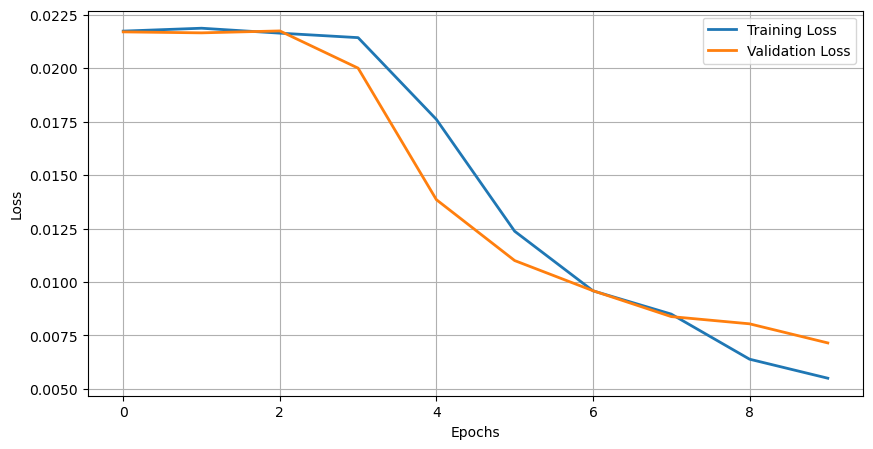

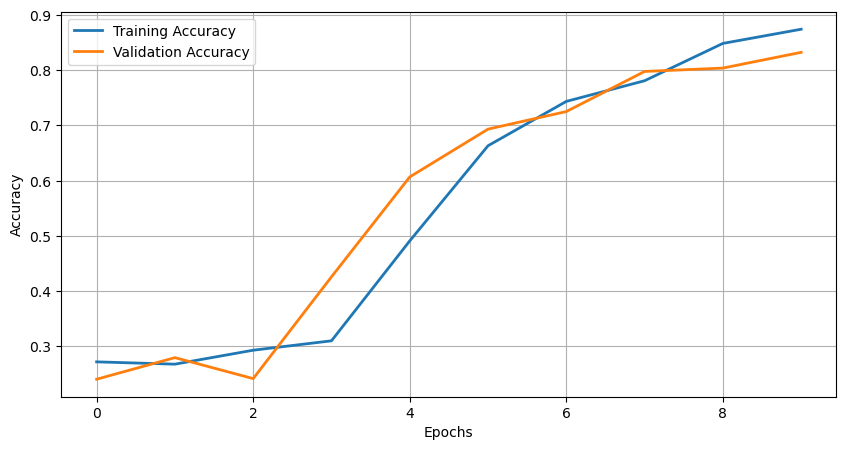

In [ ]:
 import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
tokenizer = tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_dataset = Dataset(val_encodings, y_val.tolist())

C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


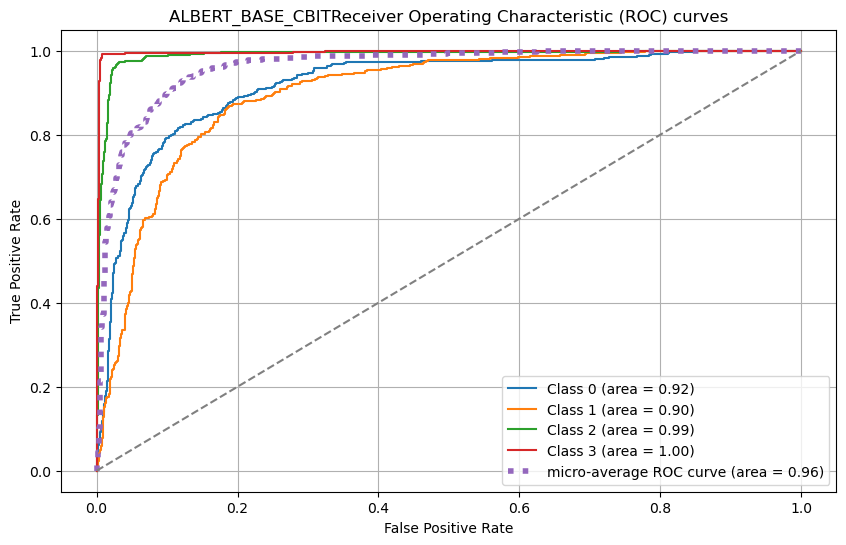

In [ ]:
"""
ALBERT_BASE_CBIT VALIDATION ON CBIT AND ROC AUC CURVE

"""
cbit_eval(val_dataset=val_dataset,batch_size=64,modelname="ALBERT_BASE_CBIT")

# 5. ROBERTA TRAINING

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

data = pd.read_csv(r"C:\Users\l\Desktop\proj\MP\BERT-Based-Approach-for-Automating-Course-Articulation-Matrix-Construction-with-Explainable-AI-main\DATASET\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]

X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")
roberta_model_save_path = 'roberta_model_trained.pth'
torch.save(model.state_dict(), roberta_model_save_path)

print(f"Model saved to {roberta_model_save_path}")

C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 112/112 [06:42<00:00,  3.59s/it]


Epoch 1/10, Train Loss: 0.0159, Train Acc: 0.5406, Train Precision: 0.5284, Train Recall: 0.5406, Train F1: 0.5208, Valid Loss: 0.0102, Valid Acc: 0.7073, Valid Precision: 0.7103, Valid Recall: 0.7073, Valid F1: 0.6911, Epoch Time: 411.96 seconds


100%|██████████| 112/112 [06:23<00:00,  3.42s/it]


Epoch 2/10, Train Loss: 0.0076, Train Acc: 0.7966, Train Precision: 0.7900, Train Recall: 0.7966, Train F1: 0.7918, Valid Loss: 0.0060, Valid Acc: 0.8363, Valid Precision: 0.8338, Valid Recall: 0.8363, Valid F1: 0.8329, Epoch Time: 392.68 seconds


100%|██████████| 112/112 [06:38<00:00,  3.55s/it]


Epoch 3/10, Train Loss: 0.0053, Train Acc: 0.8624, Train Precision: 0.8600, Train Recall: 0.8624, Train F1: 0.8610, Valid Loss: 0.0051, Valid Acc: 0.8704, Valid Precision: 0.8672, Valid Recall: 0.8704, Valid F1: 0.8680, Epoch Time: 407.56 seconds


100%|██████████| 112/112 [06:37<00:00,  3.55s/it]


Epoch 4/10, Train Loss: 0.0037, Train Acc: 0.9072, Train Precision: 0.9066, Train Recall: 0.9072, Train F1: 0.9069, Valid Loss: 0.0039, Valid Acc: 0.9045, Valid Precision: 0.9034, Valid Recall: 0.9045, Valid F1: 0.9037, Epoch Time: 407.24 seconds


100%|██████████| 112/112 [06:17<00:00,  3.37s/it]


Epoch 5/10, Train Loss: 0.0028, Train Acc: 0.9338, Train Precision: 0.9335, Train Recall: 0.9338, Train F1: 0.9336, Valid Loss: 0.0035, Valid Acc: 0.9162, Valid Precision: 0.9153, Valid Recall: 0.9162, Valid F1: 0.9156, Epoch Time: 387.10 seconds


100%|██████████| 112/112 [06:16<00:00,  3.36s/it]


Epoch 6/10, Train Loss: 0.0021, Train Acc: 0.9504, Train Precision: 0.9503, Train Recall: 0.9504, Train F1: 0.9504, Valid Loss: 0.0053, Valid Acc: 0.8799, Valid Precision: 0.8905, Valid Recall: 0.8799, Valid F1: 0.8754, Epoch Time: 385.78 seconds


100%|██████████| 112/112 [06:19<00:00,  3.38s/it]


Epoch 7/10, Train Loss: 0.0019, Train Acc: 0.9557, Train Precision: 0.9556, Train Recall: 0.9557, Train F1: 0.9556, Valid Loss: 0.0029, Valid Acc: 0.9313, Valid Precision: 0.9310, Valid Recall: 0.9313, Valid F1: 0.9308, Epoch Time: 388.24 seconds


100%|██████████| 112/112 [06:18<00:00,  3.38s/it]


Epoch 8/10, Train Loss: 0.0012, Train Acc: 0.9733, Train Precision: 0.9733, Train Recall: 0.9733, Train F1: 0.9733, Valid Loss: 0.0025, Valid Acc: 0.9408, Valid Precision: 0.9406, Valid Recall: 0.9408, Valid F1: 0.9402, Epoch Time: 387.19 seconds


100%|██████████| 112/112 [06:23<00:00,  3.43s/it]


Epoch 9/10, Train Loss: 0.0013, Train Acc: 0.9686, Train Precision: 0.9685, Train Recall: 0.9686, Train F1: 0.9685, Valid Loss: 0.0028, Valid Acc: 0.9508, Valid Precision: 0.9506, Valid Recall: 0.9508, Valid F1: 0.9505, Epoch Time: 393.09 seconds


100%|██████████| 112/112 [06:16<00:00,  3.36s/it]


Epoch 10/10, Train Loss: 0.0007, Train Acc: 0.9860, Train Precision: 0.9860, Train Recall: 0.9860, Train F1: 0.9860, Valid Loss: 0.0034, Valid Acc: 0.9391, Valid Precision: 0.9405, Valid Recall: 0.9391, Valid F1: 0.9388, Epoch Time: 385.59 seconds
Total training time: 3946.42 seconds
Model saved to roberta_model_trained.pth


In [ ]:
model.save_pretrained("ROBERTA_BASE_CBIT")

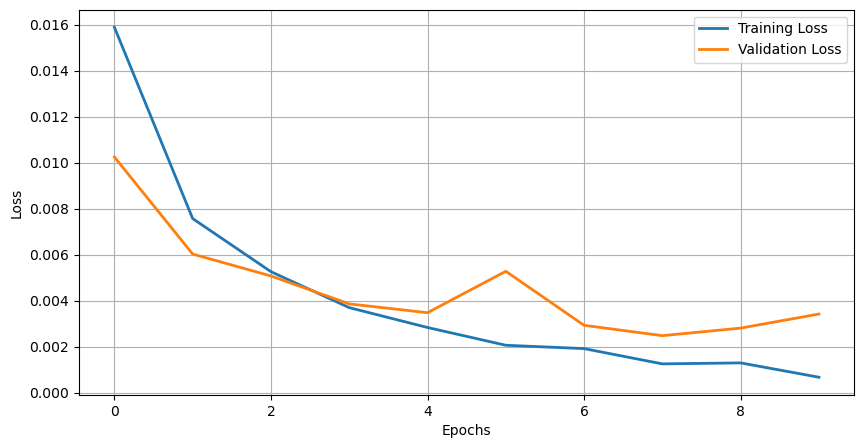

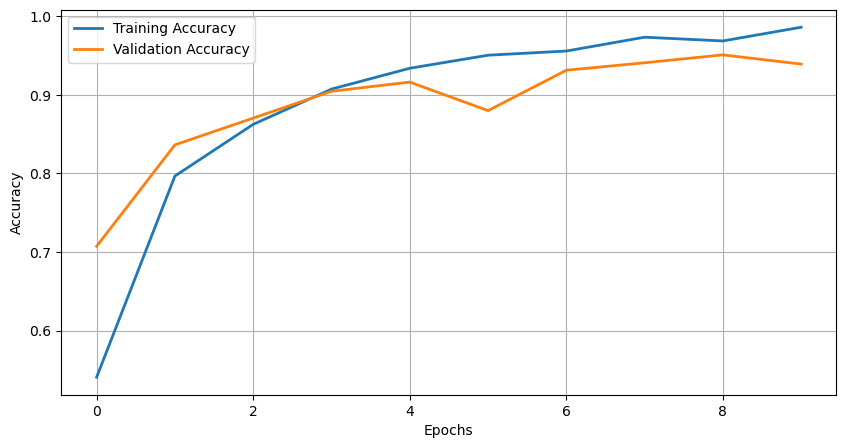

In [ ]:
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_dataset = Dataset(val_encodings, y_val.tolist())

C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


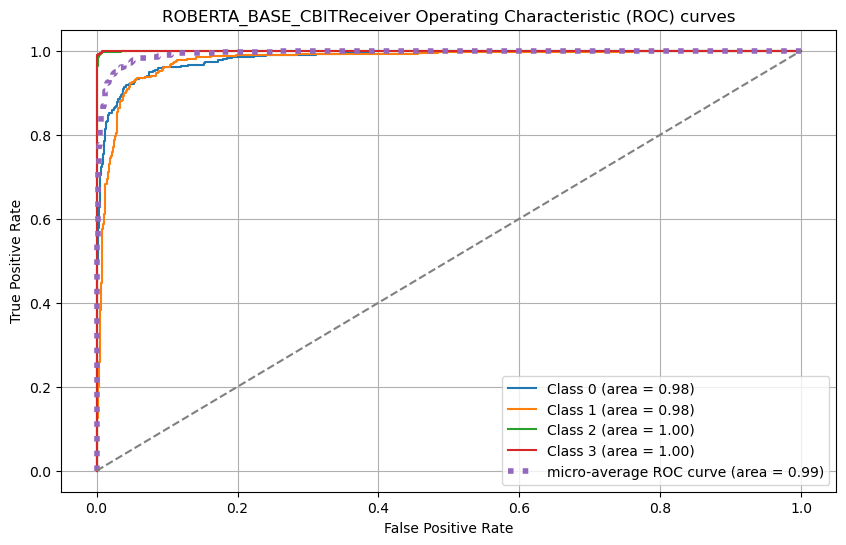

In [ ]:
cbit_eval(val_dataset=val_dataset,batch_size=64,modelname="ROBERTA_BASE_CBIT")

# 6. COMBINED AUC CURVES FOR BERT MODELS

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
data = pd.read_csv(r"C:\Users\l\Desktop\proj\MP\BERT-Based-Approach-for-Automating-Course-Articulation-Matrix-Construction-with-Explainable-AI-main\DATASET\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]

X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def combined_cbit_eval(batch_size=64, modelnames=["BERT_BASE_CBIT","DISTILBERT_BASE_CBIT","ALBERT_BASE_CBIT","ROBERTA_BASE_CBIT"],tokenizers=['bert-base-uncased','distilbert-base-uncased','albert-base-v2','roberta-base']):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    all_fpr = {}
    all_tpr = {}
    all_roc_auc = {}

    for idx in range(len(modelnames)):
        modelname = modelnames[idx]
        tokenzname = tokenizers[idx]
        tokenizer = AutoTokenizer.from_pretrained(tokenzname)

        val_encodings = tokenizer(
            list(X_val_co),
            list(X_val_po_pso),
            truncation=True,
            padding=True,
            max_length=512
        )

        val_dataset = Dataset(val_encodings, y_val.tolist())


        model = AutoModelForSequenceClassification.from_pretrained(modelname, num_labels=4)
        model.to(device).eval()
        all_valid_preds = []
        all_valid_labels = []

        with torch.no_grad():
            for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                all_valid_preds.append(outputs.logits)
                all_valid_labels.append(labels)

        all_valid_preds = torch.cat(all_valid_preds)
        all_valid_labels = torch.cat(all_valid_labels)

        labels_one_hot = torch.nn.functional.one_hot(all_valid_labels, num_classes=all_valid_preds.shape[1]).cpu().numpy()
        preds = all_valid_preds.cpu().numpy()
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(preds.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(labels_one_hot[:, i], preds[:, i])
            roc_auc[i] = roc_auc_score(labels_one_hot[:, i], preds[:, i])

        fpr["micro"], tpr["micro"], _ = roc_curve(labels_one_hot.ravel(), preds.ravel())
        roc_auc["micro"] = roc_auc_score(labels_one_hot, preds, average="micro")

        all_fpr[modelname] = fpr
        all_tpr[modelname] = tpr
        all_roc_auc[modelname] = roc_auc

    plt.figure(figsize=(10, 6))
    colors = ['blue', 'red', 'orange', 'green']
    for idx, modelname in enumerate(modelnames):
        fpr = all_fpr[modelname]
        tpr = all_tpr[modelname]
        roc_auc = all_roc_auc[modelname]
        plt.plot(fpr["micro"], tpr["micro"], color=colors[idx], linestyle='--', linewidth=2, label=f'{ modelname.lower()[:-5]} micro-average (area = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('combined  Receiver Operating Characteristic (ROC) curves for all bert models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\l\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by

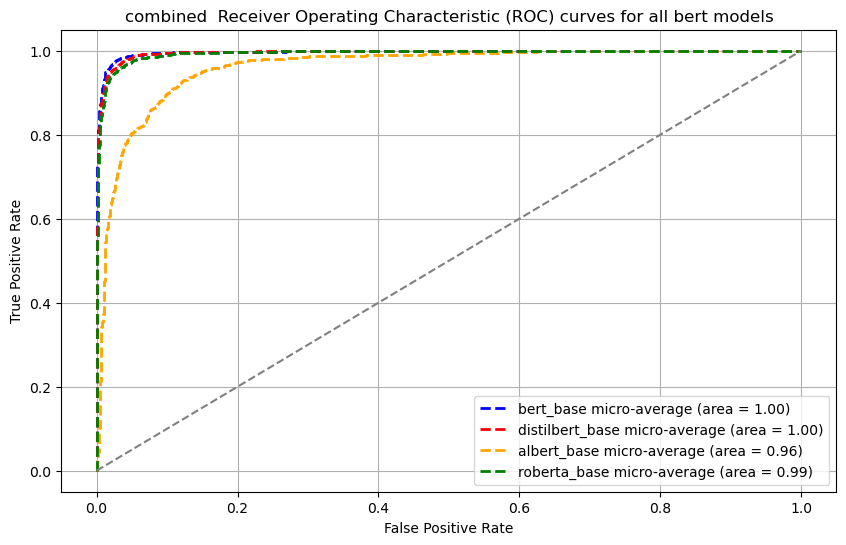

In [ ]:
combined_cbit_eval(batch_size=64)

# 7. MODEL PERFORMANCE PLOT ALL IN ONE

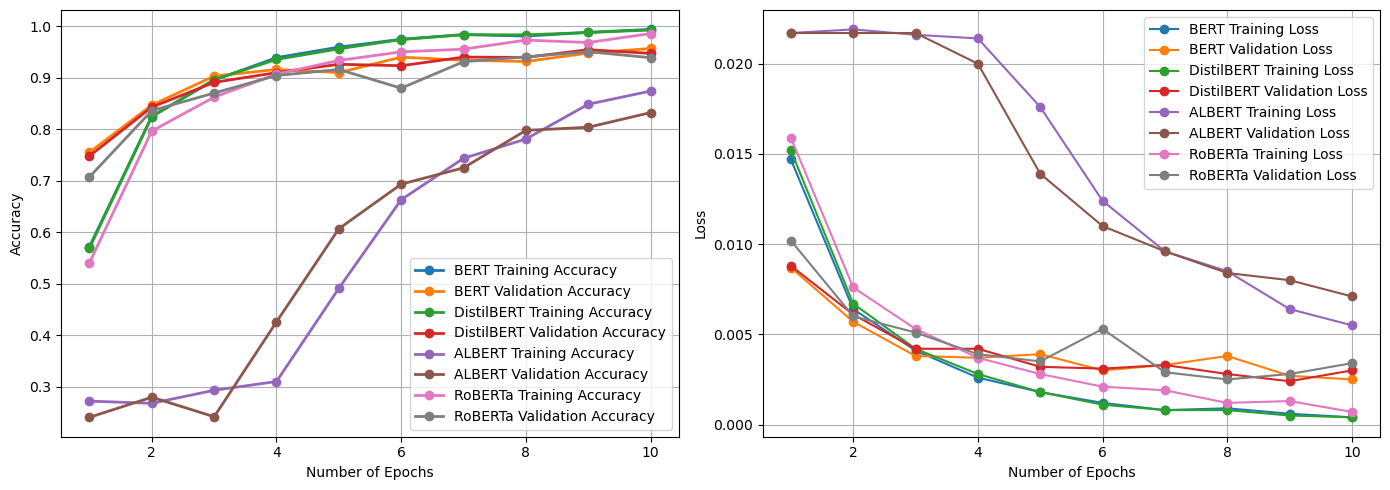

In [ ]:
#summarized plot.
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

bert_train_loss = [0.0147, 0.0064, 0.0041, 0.0026, 0.0018, 0.0012, 0.0008, 0.0009, 0.0006, 0.0004]
bert_val_loss = [0.0087, 0.0057, 0.0038, 0.0037, 0.0039, 0.0030, 0.0033, 0.0038, 0.0027, 0.0025]
bert_train_acc = [0.5719, 0.8247, 0.8955, 0.9392, 0.9596, 0.9749, 0.9841, 0.9811, 0.9883, 0.9941]
bert_val_acc = [0.7553, 0.8469, 0.9034, 0.9162, 0.9101, 0.9402, 0.9341, 0.9318, 0.9480, 0.9570]

distilbert_train_loss = [0.0152, 0.0067, 0.0042, 0.0028, 0.0018, 0.0011, 0.0008, 0.0008, 0.0005, 0.0004]
distilbert_val_loss = [0.0088, 0.0061, 0.0042, 0.0042, 0.0032, 0.0031, 0.0033, 0.0028, 0.0024, 0.0030]
distilbert_train_acc = [0.5692, 0.8251, 0.8965, 0.9357, 0.9564, 0.9744, 0.9837, 0.9835, 0.9881, 0.9929]
distilbert_val_acc = [0.7480, 0.8430, 0.8911, 0.9101, 0.9263, 0.9235, 0.9402, 0.9397, 0.9547, 0.9475]

albert_train_loss = [0.0217, 0.0219, 0.0216, 0.0214, 0.0176, 0.0124, 0.0096, 0.0085, 0.0064, 0.0055]
albert_val_loss = [0.0217, 0.0217, 0.0217, 0.0200, 0.0139, 0.0110, 0.0096, 0.0084, 0.0080, 0.0071]
albert_train_acc = [0.2717, 0.2675, 0.2928, 0.3098, 0.4909, 0.6632, 0.7435, 0.7810, 0.8486, 0.8743]
albert_val_acc = [0.2402, 0.2793, 0.2413, 0.4257, 0.6067, 0.6933, 0.7251, 0.7978, 0.8039, 0.8324]

roberta_train_loss = [0.0159, 0.0076, 0.0053, 0.0037, 0.0028, 0.0021, 0.0019, 0.0012, 0.0013, 0.0007]
roberta_val_loss = [0.0102, 0.0060, 0.0051, 0.0039, 0.0035, 0.0053, 0.0029, 0.0025, 0.0028, 0.0034]
roberta_train_acc = [0.5406, 0.7966, 0.8624, 0.9072, 0.9338, 0.9504, 0.9557, 0.9733, 0.9686, 0.9860]
roberta_val_acc = [0.7073, 0.8363, 0.8704, 0.9045, 0.9162, 0.8799, 0.9313, 0.9408, 0.9508, 0.9391]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, bert_train_acc, 'o-', label="BERT Training Accuracy", linewidth=2)
plt.plot(epochs, bert_val_acc, 'o-', label="BERT Validation Accuracy", linewidth=2)
plt.plot(epochs, distilbert_train_acc, 'o-', label="DistilBERT Training Accuracy", linewidth=2)
plt.plot(epochs, distilbert_val_acc, 'o-', label="DistilBERT Validation Accuracy", linewidth=2)
plt.plot(epochs, albert_train_acc, 'o-', label="ALBERT Training Accuracy", linewidth=2)
plt.plot(epochs, albert_val_acc, 'o-', label="ALBERT Validation Accuracy", linewidth=2)
plt.plot(epochs, roberta_train_acc, 'o-', label="RoBERTa Training Accuracy", linewidth=2)
plt.plot(epochs, roberta_val_acc, 'o-', label="RoBERTa Validation Accuracy", linewidth=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, bert_train_loss, 'o-', label="BERT Training Loss")
plt.plot(epochs, bert_val_loss, 'o-', label="BERT Validation Loss")
plt.plot(epochs, distilbert_train_loss, 'o-', label="DistilBERT Training Loss")
plt.plot(epochs, distilbert_val_loss, 'o-', label="DistilBERT Validation Loss")
plt.plot(epochs, albert_train_loss, 'o-', label="ALBERT Training Loss")
plt.plot(epochs, albert_val_loss, 'o-', label="ALBERT Validation Loss")
plt.plot(epochs, roberta_train_loss, 'o-', label="RoBERTa Training Loss")
plt.plot(epochs, roberta_val_loss, 'o-', label="RoBERTa Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
r = np.arange(4)
r

array([0, 1, 2, 3])

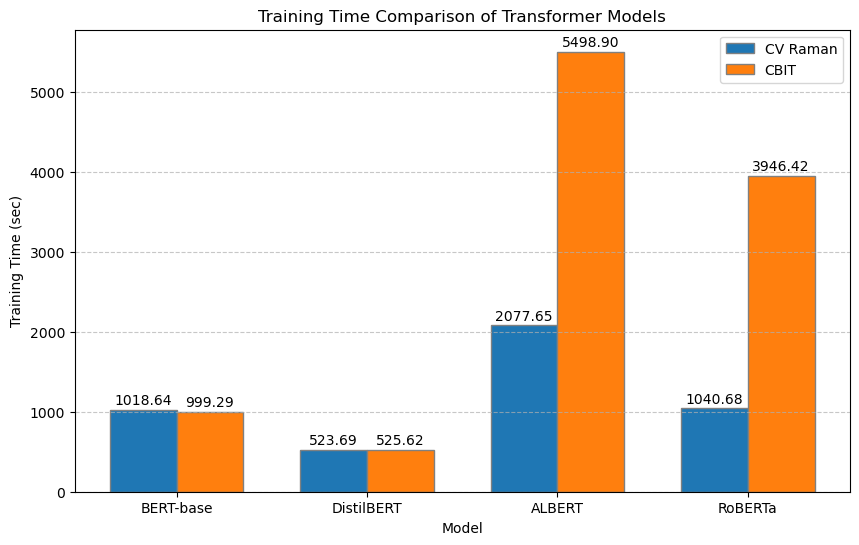

In [ ]:
#Training Time Comparison of Transformer Models.
import matplotlib.pyplot as plt
import numpy as np

# Models and their training times on two datasets
models = ['BERT-base', 'DistilBERT', 'ALBERT', 'RoBERTa']
training_time_cv_raman = [1018.64, 523.69, 2077.65, 1040.68]
training_time_cbit = [999.29, 525.62, 5498.90, 3946.42]

bar_width = 0.35
r = np.arange(len(models))

plt.figure(figsize=(10, 6))

# Create bars
plt.bar(r, training_time_cv_raman, width=bar_width, edgecolor='grey', label='CV Raman')
plt.bar(r + bar_width, training_time_cbit, width=bar_width, edgecolor='grey', label='CBIT')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Training Time (sec)')
plt.title('Training Time Comparison of Transformer Models')
plt.xticks(r + bar_width / 2, models)

for i in range(len(models)):
    plt.text(i, training_time_cv_raman[i] + 30, f'{training_time_cv_raman[i]:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    plt.text(i + bar_width, training_time_cbit[i] + 30, f'{training_time_cbit[i]:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
